# Week3: Groverアルゴリズムを用いたMAXCUT問題の解決
この週では、Week2で学んだGroverアルゴリズムを用いて単純なMAXCUT問題を解決します。

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

## MAXCUT問題

MAXCUT問題とは、与えられたグラフG(V,E)の頂点Vを二つの部分グラフS,Tに分割（カット）する際に、  
S-T間に存在するエッジ（カットエッジ）の本数が最大となるような分割(最大カット)を見つける問題です。

### 量子アルゴリズムによる解決
量子アルゴリズムによるMAXCUT問題の解法は、  
[Quantum Approximate Optimization Algorithm (QAOA)](https://qiskit.org/documentation/aqua/optimization/qiskit_optimization.html) を用いたものや  
[Variational Quantum Eigensolver (VQE)](https://medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747)を用いたものも知られていますが、  
ここでは、Week２で学んだGroverアルゴリズムを用いて解いてみましょう。

とても簡単な例として、  
頂点が（0,1,2）の３個  
辺が（0,1),(1,2)の２本からなるグラフのカットを考えてみます。  
<img src="maxcut.png" width="320">


２つのゾーン、０と1に頂点を振り分けて（カットして）、  
境界線を横切る辺（カットエッジ）の数(value)を  最大化することで最大カットを求める事ができます。  
(最大カットはもちろん２です。)

### 量子回路でカットエッジを判定する
まずはオラクルの設計をしてみましょう。  
グラフをカットした時、ある辺(a,b)がカットエッジかどうか判定する回路を考えてみます。

辺の両端a,bが同じ部分グラフに入っている場合に0、  
異なる部分グラフに含まれている場合に１と判定します。  
１量子ビットを１頂点に対応させ、二つの部分グラフを0と1で表すと、  
真理値表はXOR回路と同等のものになります。

|頂点a|頂点b|判定|
|--|--|--|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|0|

対応する量子回路を以下に示します。  
全ての組み合わせを同時に入力するため、頂点に対応した量子ビットにアダマールゲートを作用させています。

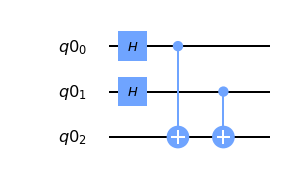

In [2]:
q = QuantumRegister(3)
qc = QuantumCircuit(q)

#cutedge checker
def ccheck(a, b, c): 
    qc.cx(q[a], q[c]) 
    qc.cx(q[b], q[c])

qc.h(q[0])
qc.h(q[1])
ccheck(0,1,2)
qc.draw(output='mpl')

## カットエッジを数え上げる
この判定回路とWeek1の(半)加算器を組み合わせることで  
入力に対応したカットエッジの本数を数え上げることができます。

今回のグラフは3頂点と２辺を持つので、  
q[0],q[1],q[2]に頂点が含まれている部分グラフの情報を、  
q[3],q[4]にカットエッジの判定結果を、  
q[5],q[6]にカットエッジの本数をそれぞれ格納します。

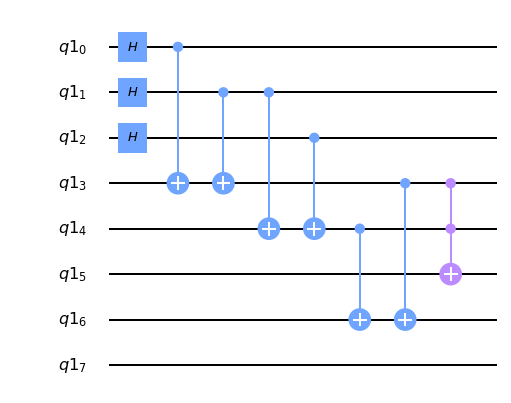

In [3]:
q = QuantumRegister(8)
qc = QuantumCircuit(q)

#half adder
#入力: a,b
#出力:和s,キャリーc
def hadder(a,b,s,c):
    #XOR
    qc.cx(q[b], q[s])
    qc.cx(q[a], q[s])
    #AND
    qc.ccx(q[a], q[b], q[c])

qc.h(q[0:3])
ccheck(0,1,3)
ccheck(1,2,4)
hadder(3,4,6,5)

qc.draw(output='mpl')

これでカットエッジの本数を数える回路が出来上がりましたが、  
Groverのアルゴリズムのためのオラクルとして用いるためには
YesかNoで答えられる質問を用意する必要があります。

## MAXCUTのためのオラクル回路
そこでしきい値を2に設定し、桁上げ出力(q[5])が1であるかを確認することで  
”カットエッジが2本（またはそれ以上）であるかどうか”を判別するオラクル回路を作ってみましょう。

{'1': 24957, '0': 75043}


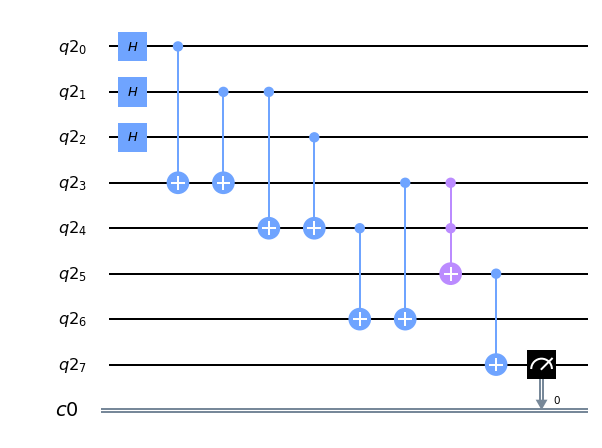

In [4]:
q = QuantumRegister(8)
c = ClassicalRegister(1)
qc = QuantumCircuit(q,c)

qc.h(q[0:3])
ccheck(0,1,3)
ccheck(1,2,4)
hadder(3,4,6,5)
qc.cx(q[5],q[7])
qc.measure(q[7], c[0])

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=100000)
result = job.result()
count =result.get_counts()
print(count)
qc.draw(output='mpl')

約25％の結果が1となりました。
今回の場合、カットエッジが2本となる入力は010と101なので、このオラクルは妥当なようです。  

q[7]の初期状態を|->状態へ、cx(q[5],q[7])をcz(q[5],q[7])へと変更することで  
010と101に対して符号反転を行うことができます。

符号反転を行ったあとはここまでの逆順の操作を行うことでq[3]からq[6]を初期状態へと戻します。
この操作は、入力Qubit(q[0]からq[2])とオラクル計算のためのQubit間の不要なエンタングルメントの消去に必要です。

{'0000000': 130, '0000010': 114, '0000001': 119, '0000100': 122, '0000011': 130, '0000110': 123, '0000111': 135, '0000101': 127}


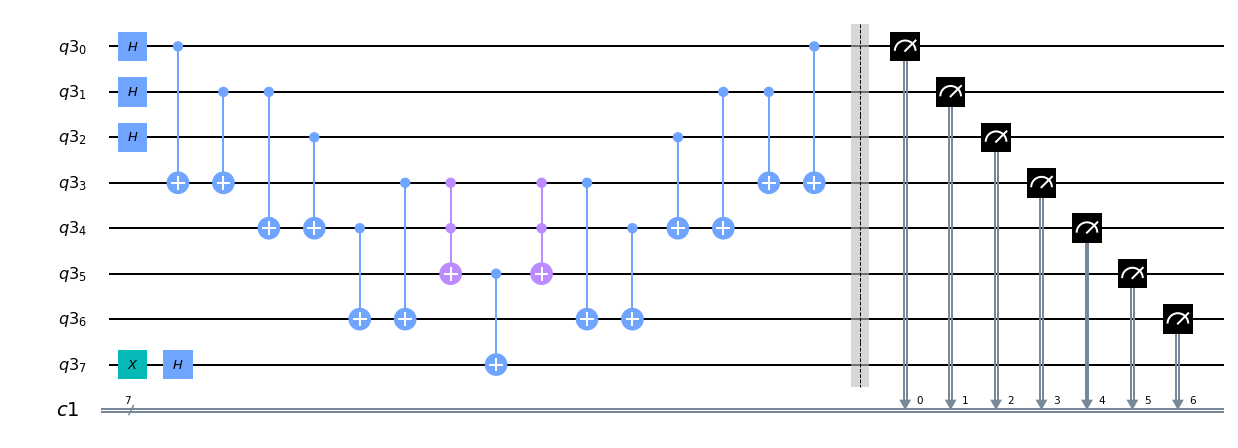

In [5]:
q = QuantumRegister(8)
c = ClassicalRegister(7)
qc = QuantumCircuit(q,c)

#inverse operations
def iccheck(a, b, c): 
    qc.cx(q[b], q[c])
    qc.cx(q[a], q[c]) 
def ihadder(a,b,s,c):
    qc.ccx(q[a], q[b], q[c])
    qc.cx(q[a], q[s])
    qc.cx(q[b], q[s])

qc.h(q[0:3])
qc.x(q[7])
qc.h(q[7])

ccheck(0,1,3)
ccheck(1,2,4)
hadder(3,4,6,5)
qc.cx(q[5],q[7])
ihadder(3,4,6,5)
iccheck(1,2,4)
iccheck(0,1,3)
qc.barrier()
qc.measure(q[0:7], c[0:7])

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
result = job.result()
count =result.get_counts()
print(count)
qc.draw(output='mpl')

等確率で８種類の出力が得られていることと、q[3]~q[6]が初期状態に戻っていることが確認できます。  
符号反転の状態は確率分布から確認することはできません。  
（測定されないq[7]は常に|->状態です。）

# 回路の完成
Diffusion回路を付け加えることで、MAXCUT問題に対するGroverのアルゴリズムが完成します。  
高い確率で正解を得られるか確認してみましょう。

{'010': 5009, '101': 4991}


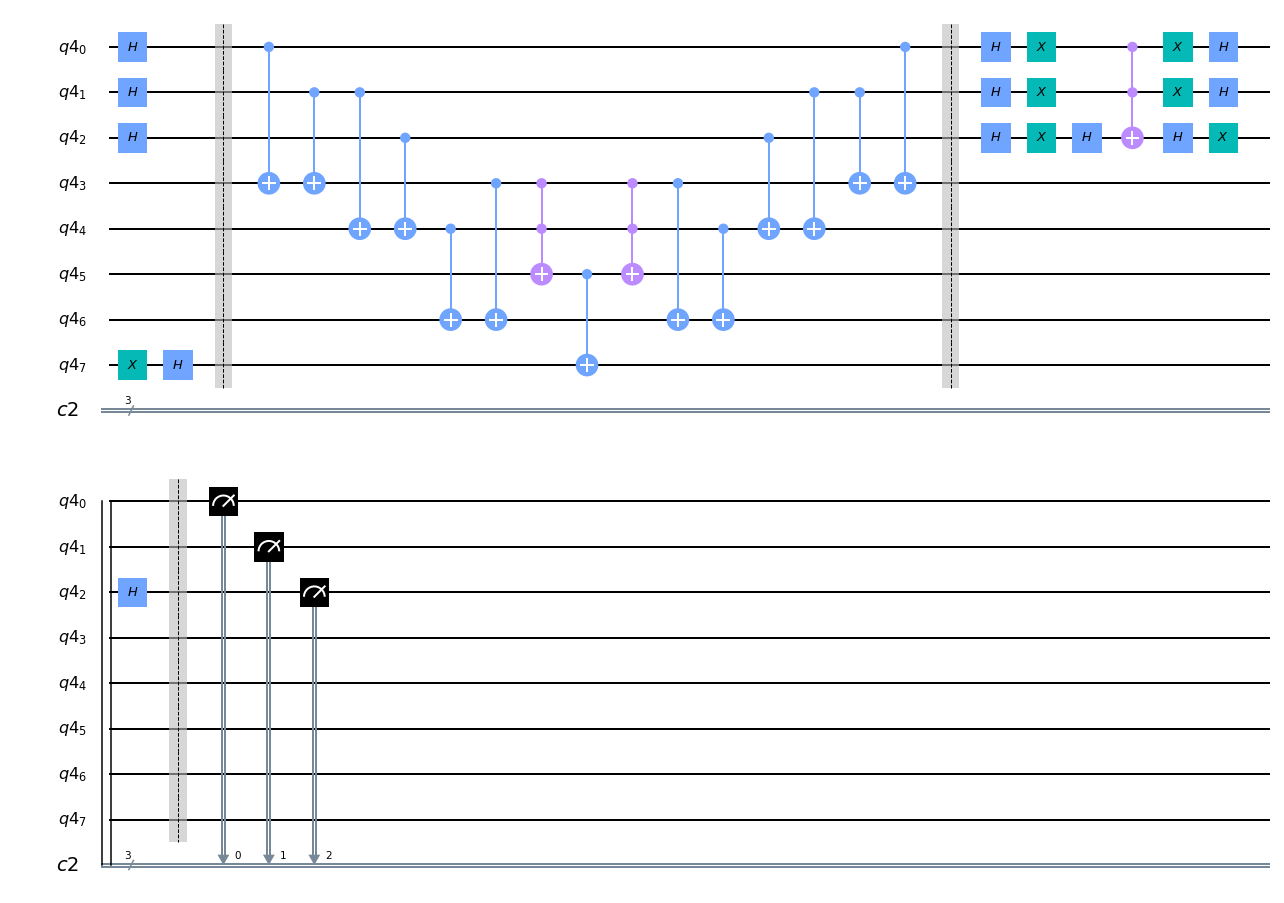

In [6]:
q = QuantumRegister(8)
c = ClassicalRegister(3)
qc = QuantumCircuit(q,c)

#diffusion operations
def diffusion(a,b,c):
    qc.h(q[a])
    qc.h(q[b])
    qc.h(q[c])    
    qc.x(q[a])
    qc.x(q[b])
    qc.x(q[c])
    qc.h(q[c])  
    qc.ccx(q[a],q[b], q[c])
    qc.h(q[c])  
    qc.x(q[a])
    qc.x(q[b])
    qc.x(q[c])
    qc.h(q[a])
    qc.h(q[b])
    qc.h(q[c])

#initialization
qc.h(q[0:3])
qc.x(q[7])
qc.h(q[7])
qc.barrier()

#oracle part
ccheck(0,1,3)
ccheck(1,2,4)
hadder(3,4,6,5)
qc.cx(q[5],q[7])
ihadder(3,4,6,5)
iccheck(1,2,4)
iccheck(0,1,3)
qc.barrier()

#diffusion part
diffusion(0,1,2)
qc.barrier()
qc.measure(q[0:3], c[0:3])

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=10000)
result = job.result()
count =result.get_counts()
print(count)
qc.draw(output='mpl')

## 今週の問題・・の前にTips
### $C^{\otimes n-1}$NOTゲートの実装について
$ n $ Qubitに対する拡散変換を行うには、  
$C^{\otimes n-1}$NOTゲートが必要となります。  
Qiskitには以下の関数が用意されています。  

**mct(q_controls, q_target, q_ancilla, mode='basic')**

MCTゲートを用いることで複数のControl 量子ビットをもつToffoli gateを呼び出すことができます。  
なお、MCTゲートを1〜2量子ビットゲートに分解する手法としては[1]や、補助量子ビット(ancilla)を用いない[2]などが知られています。  
[1]A. Barenco (Oxford), C. H. Bennett (IBM), R. Cleve (Calgary), D. P. DiVincenzo (IBM), N. Margolus (MIT), P. Shor (AT&amp;T), T. Sleator (NYU), J. Smolin(UCLA), H. Weinfurter (Innsbruck),**Elementary gates for quantum computation** , arXiv:quant-ph/9503016 (1995)  
[2]Mehdi Saeedi, Massoud Pedram, **Linear-Depth Quantum Circuits for n-qubit Toffoli gates with no Ancilla**,  arXiv:1303.3557 (2013)

# 今週の問題（ラーニングチャレンジ演習 ⅡI）

頂点　V:　(0,1,2,3)  
辺　E:　（0,1),(0,2),(0,3)  
となるグラフG（V,E）が与えられた時にカットエッジ数が３となるような入力を  
Iteration = 2回のGroverアルゴリズムを用いて求め、回路の量子コストを算出せよ.

**求めてほしい結果:**<br/>
(a)問題を解くために設計した量子回路.<br/>
(b)シミュレーターの実行結果から、最も確率振幅が高い量子ビット列を求めてください.<br/> 
(c)Unrollerを用いて、作成した量子回路の量子コストを算出するのに必要なゲートカウント. <br/>

**提出物:**<br/>
今週のチャレンジでは、以下２つのファイルの提出をお願いします.<br/>
1.上記 (a)の量子回路をpythonファイル (.py) または ipython notebook (.ipynb)で保存したもの.<br/>
2.textファイルの1行目に上記(b)、2行目に上記(c)の結果を貼り付けて保存したもの.<br/>

txtファイルはご自身のパソコンのメモ帳またはテキストエディターを開いて作成いただいても良いですし、下記のサンプルコードを使ってtxtファイルを生成いただいてもかまいません.生成したファイルには(c)の結果が自動的に貼り付けられますので、ご自身で(b)を1行目に追加して保存してください.
```sample_output.py
import json
dct = qc.count_ops()
with open('wk3_output.txt', 'w') as f:
    f.write(json.dumps(dct))
```
Example output:<br/>
1000, 0111<br/>
{"u3": 46, "cx": 31, "barrier": 3, "measure": 3}<br/>

作成した量子回路をUnrollerを用いてu3とCXなどのエレメンタリーゲートに分解する方法については、[量子回路のコスト計算について](https://github.com/quantum-challenge/2019/blob/master/problems/how_to_calculate_quantum_cost.ipynb)を参照してください.

ラーニングチャレンジⅠからⅢまでの結果ファイルは [提出フォーム](https://angelhack.typeform.com/to/AakobE)から送信をお願いします.

## 解答例
|1000>もしくは|0111>の確率が最大となる回路を構成します。   
- q[7]は補助量子ビットになります。
- Adderを用いずにカットエッジが3であるかどうか判定しています。
- Iterationの回数を1や3に変更すると正解確率が変化します。（2で最大となる）

**注意：**
|1000>もしくは|0111>を観測すると、古典ビットがc[3],c[2],c[1],c[0]の順番で並んだものが得られるため, それぞれ観測結果は0001,1110になることに注意してください。

{'1000': 41, '1101': 41, '1100': 53, '0011': 30, '0111': 37, '1110': 4602, '1111': 52, '0000': 32, '0110': 36, '0010': 41, '0001': 4844, '0100': 41, '1001': 31, '1011': 33, '1010': 44, '0101': 42}


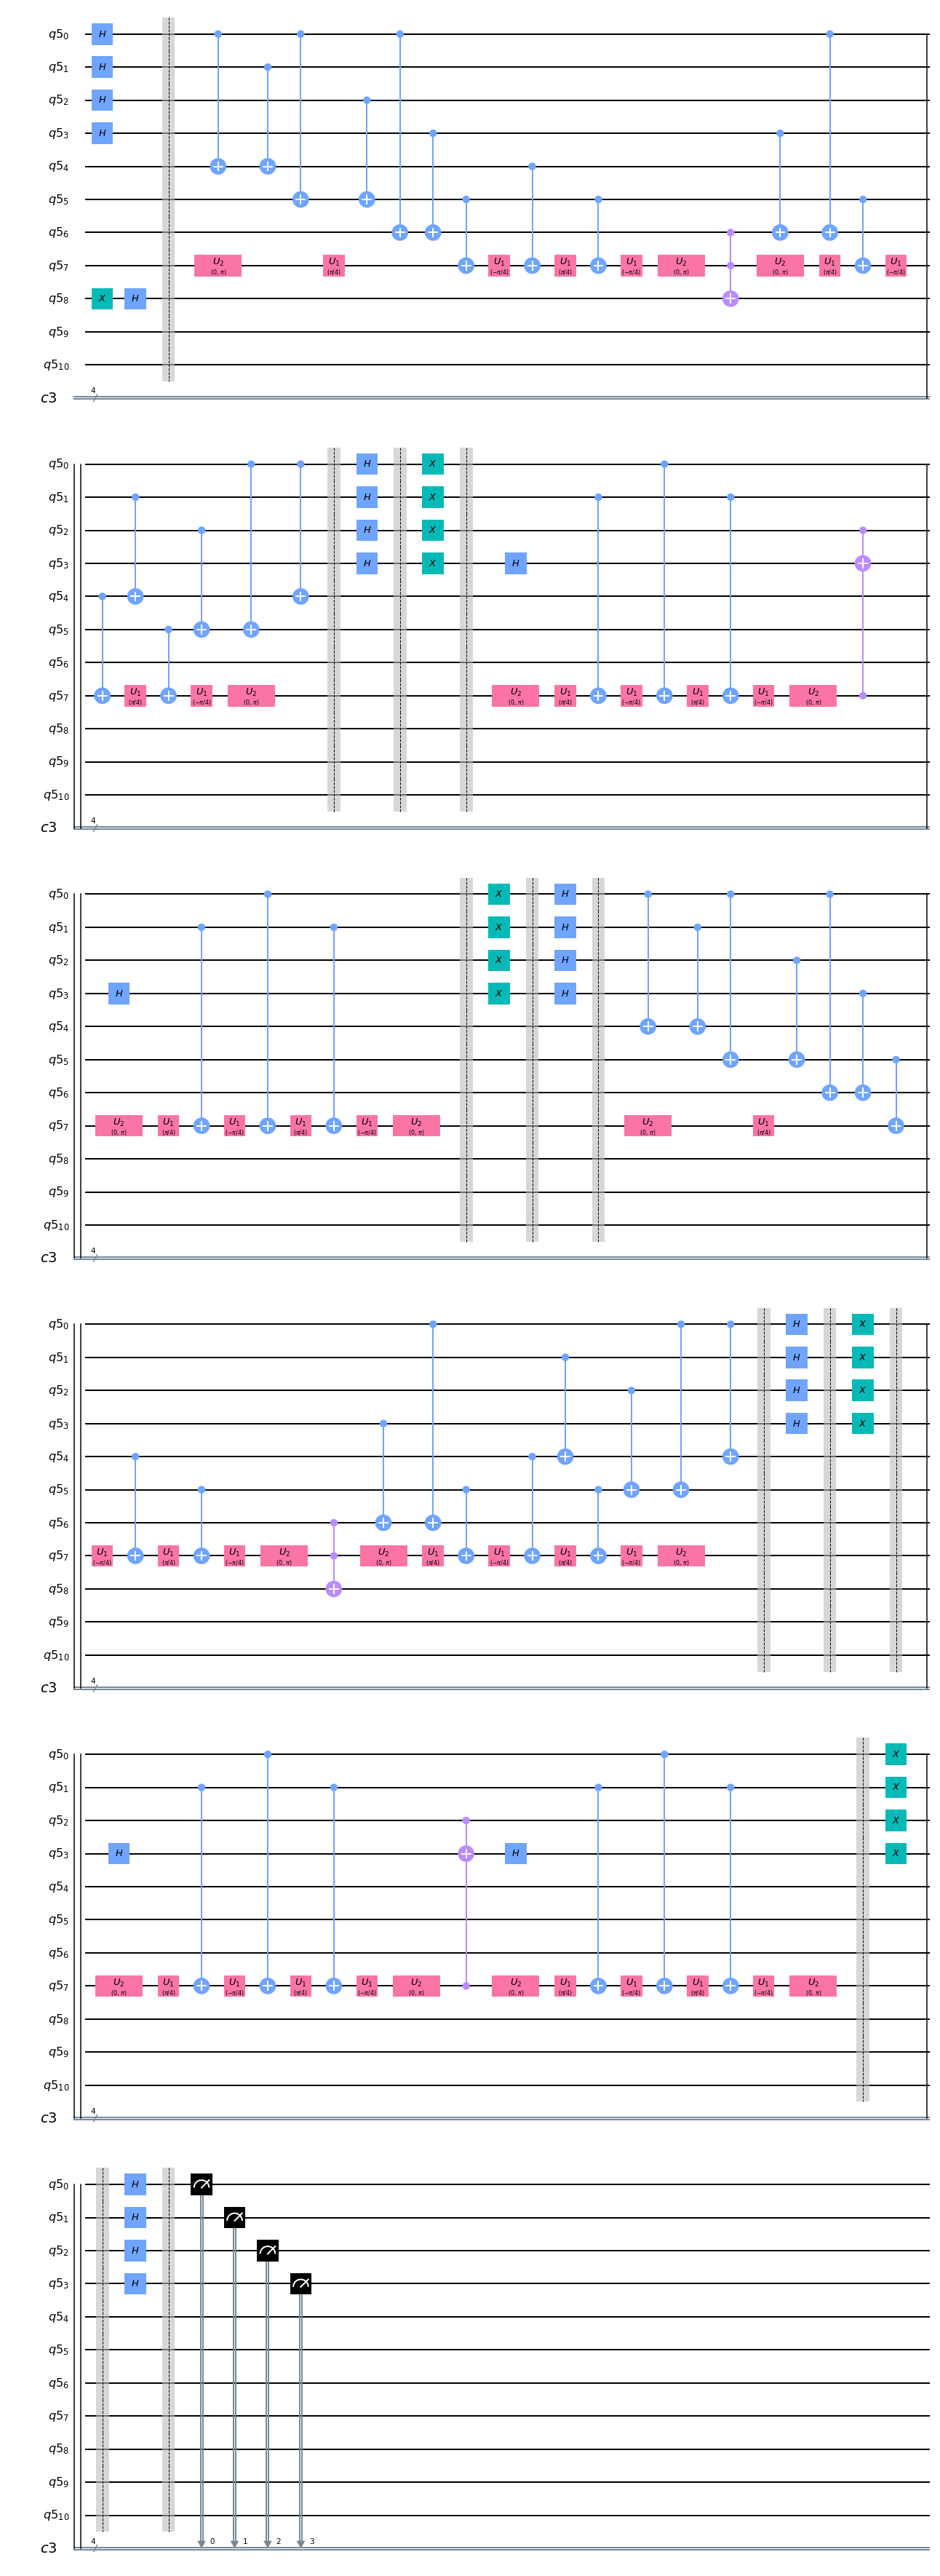

In [7]:
#from qiskit.aqua.circuits.gates import mct
q = QuantumRegister(11)
c = ClassicalRegister(4)
qc = QuantumCircuit(q,c)
ite = 2 #number of iteration

#initialization
qc.h(q[0:4])
qc.x(q[8])
qc.h(q[8])
qc.barrier()

for i in range(ite):
#oracle part
    ccheck(0,1,4)
    ccheck(0,2,5)
    ccheck(0,3,6) 
    qc.mct([q[4],q[5],q[6]], q[8] , [q[7]], mode='basic')
    iccheck(0,3,6)
    iccheck(0,2,5)
    iccheck(0,1,4)
    qc.barrier()
#diffusion part
    qc.h(q[0:4])
    qc.barrier()
    qc.x(q[0:4])
    qc.barrier()
    qc.h(q[3])
    qc.mct([q[0],q[1],q[2]], q[3] , [q[7]], mode='basic')
    qc.h(q[3])
    qc.barrier()
    qc.x(q[0:4])
    qc.barrier()
    qc.h(q[0:4])
    qc.barrier()

qc.measure(q[0:4], c[0:4])

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=10000)
result = job.result()
count =result.get_counts()
print(count)
qc.draw(output='mpl')

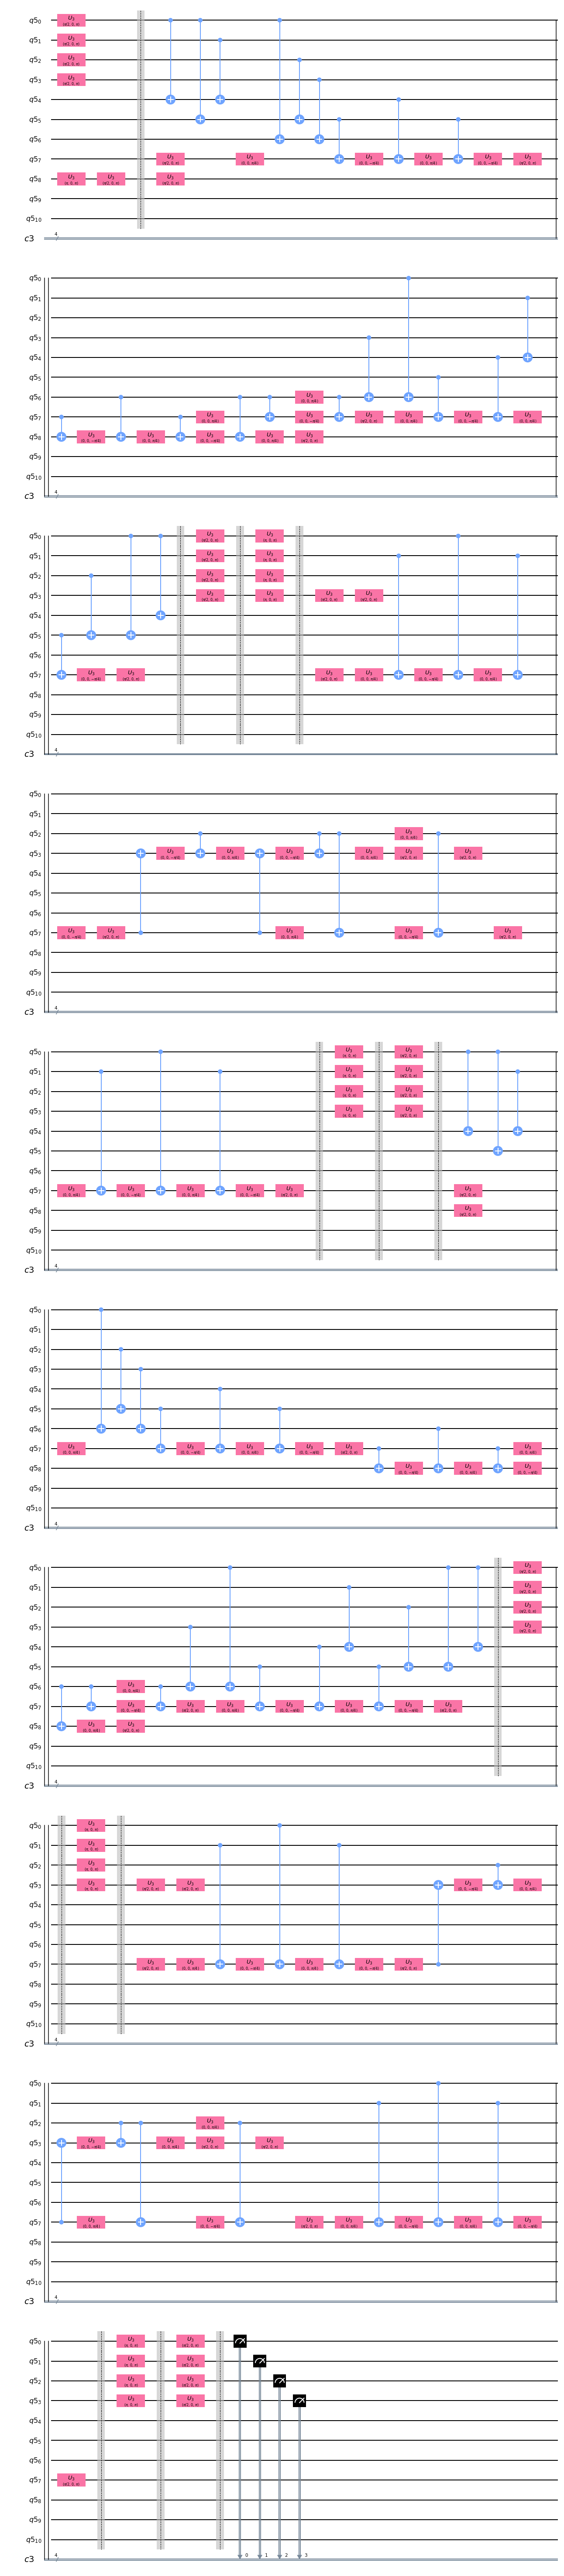

In [8]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc) 
new_circuit.draw(output='mpl')

In [9]:
new_circuit.count_ops()

OrderedDict([('u3', 126), ('cx', 72), ('barrier', 13), ('measure', 4)])

In [10]:
import json
dct = new_circuit.count_ops()
with open('wk3_output.txt', 'w') as f:
    f.write(json.dumps(dct))